<a href="https://colab.research.google.com/github/lochuynhk/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/Loc_Huynh_LS_DS11_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [68]:
df.head

<bound method NDFrame.head of         Burrito       Date  Yelp  Google  ... Avocado  Corn  Zucchini  Great
0    California  1/18/2016   3.5     4.2  ...     NaN   NaN       NaN  False
1    California  1/24/2016   3.5     3.3  ...     NaN   NaN       NaN  False
2      Carnitas  1/24/2016   NaN     NaN  ...     NaN   NaN       NaN  False
3         Asada  1/24/2016   NaN     NaN  ...     NaN   NaN       NaN  False
4    California  1/27/2016   4.0     3.8  ...     NaN   NaN       NaN   True
..          ...        ...   ...     ...  ...     ...   ...       ...    ...
418       Other  8/27/2019   NaN     NaN  ...     NaN   NaN       NaN  False
419       Other  8/27/2019   NaN     NaN  ...     NaN   NaN       NaN   True
420  California  8/27/2019   NaN     NaN  ...     NaN   NaN       NaN  False
421       Other  8/27/2019   NaN     NaN  ...     NaN   NaN       NaN   True
422       Other  8/27/2019   NaN     NaN  ...     NaN   NaN       NaN   True

[421 rows x 59 columns]>

In [0]:
from sklearn.model_selection import train_test_split

In [70]:
# Convert to datetime and look at the date range
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df['Date'].describe()

count                     421
unique                    169
top       2016-08-30 00:00:00
freq                       29
first     2011-05-16 00:00:00
last      2026-04-25 00:00:00
Name: Date, dtype: object

In [71]:
# Look at all the observations for each year
df['Date'].dt.year.value_counts()

2016    296
2017     85
2018     27
2019     10
2026      1
2015      1
2011      1
Name: Date, dtype: int64

In [72]:
# Train and split based on date
train = df[df.Date.dt.year <=2016]
val = df[df.Date.dt.year == 2017]
test = df[df.Date.dt.year >= 2018]
train.shape, test.shape, val.shape

((298, 59), (38, 59), (85, 59))

In [73]:
# Create training and validation sets (by spliting the training data)
train, val = train_test_split(train, random_state=42)

train.shape, val.shape

((223, 59), (75, 59))

In [74]:
train

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
227,California,2016-09-11,NaN,NaN,NaN,5.79,4.00,NaN,NaN,NaN,NaN,NaN,4.0,3.0,4.0,2.5,3.5,4.0,2.0,2.5,5.0,NaN,NaN,x,NaN,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
79,Other,2016-04-27,NaN,NaN,NaN,6.39,3.00,NaN,NaN,23.0,22.5,0.93,4.0,3.0,2.5,3.5,3.0,3.0,3.5,4.0,3.5,NaN,NaN,X,NaN,X,X,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
66,California,2016-04-15,4.5,4.4,x,6.25,4.00,NaN,NaN,NaN,NaN,NaN,4.5,4.5,2.5,3.5,3.5,3.5,3.0,4.0,5.0,NaN,NaN,x,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
298,California,2016-12-10,3.5,3.7,NaN,7.75,4.00,NaN,NaN,20.0,21.0,0.70,3.5,2.5,3.0,3.3,1.4,2.3,2.2,3.3,4.5,NaN,NaN,X,X,NaN,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
283,Asada,2016-11-16,NaN,NaN,NaN,6.75,3.00,NaN,NaN,18.0,21.5,0.66,4.5,4.7,4.5,3.5,4.0,4.5,4.5,3.5,5.0,NaN,NaN,x,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,California,2016-08-27,4.0,4.1,x,5.99,4.00,NaN,NaN,18.5,21.0,0.65,4.0,4.5,2.5,2.5,2.5,1.5,3.0,4.0,5.0,NaN,NaN,X,NaN,NaN,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
71,Other,2016-04-15,NaN,NaN,NaN,6.50,2.50,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.5,4.0,4.0,3.0,NaN,4.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
107,Other,2016-05-20,NaN,NaN,NaN,6.50,4.00,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,4.0,5.0,4.0,4.0,5.0,4.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
273,California,2016-11-02,NaN,NaN,NaN,6.39,4.25,NaN,NaN,22.0,22.0,0.85,2.0,4.0,3.7,2.0,4.0,4.5,4.5,2.7,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [75]:
val

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
160,California,2016-06-24,NaN,NaN,NaN,6.25,4.5,NaN,NaN,22.5,22.0,0.87,4.0,4.0,4.5,4.0,4.0,3.5,4.0,4.0,4.5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
267,Other,2016-10-27,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,3.0,2.0,2.0,NaN,1.0,5.0,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
257,Other,2016-10-17,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.5,4.2,4.7,4.4,4.0,4.9,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
9,Asada,2016-02-06,4.0,4.1,NaN,6.25,3.5,NaN,NaN,NaN,NaN,NaN,2.5,1.5,1.5,3.0,4.5,3.0,1.5,2.0,4.5,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
78,California,2016-04-27,4.5,4.4,x,6.89,3.0,NaN,NaN,25.0,22.0,0.96,3.0,2.5,3.0,2.5,2.5,2.0,3.5,3.0,4.0,NaN,NaN,X,NaN,X,x,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,Other,2016-06-01,NaN,NaN,NaN,4.87,2.5,NaN,NaN,19.5,20.5,0.65,3.5,3.0,2.5,2.4,3.5,4.5,3.0,3.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
239,California,2016-09-22,4.5,4.7,NaN,6.35,4.0,NaN,NaN,NaN,NaN,NaN,4.0,2.5,4.0,3.0,4.5,2.0,2.0,3.0,4.0,NaN,NaN,x,x,NaN,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
270,Other,2016-11-01,NaN,NaN,NaN,5.99,4.0,NaN,NaN,19.5,21.5,0.72,3.0,4.5,3.7,2.8,5.0,4.5,3.0,2.3,4.5,NaN,NaN,NaN,X,X,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
203,Surf & Turf,2016-08-30,NaN,NaN,NaN,8.25,2.0,NaN,NaN,20.0,24.5,0.96,3.5,2.0,5.0,3.5,4.0,2.5,3.5,3.0,3.5,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,False


In [76]:
test

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
77,California,2026-04-25,NaN,NaN,NaN,8.00,4.0,NaN,NaN,21.59,NaN,NaN,4.5,5.0,5.0,5.0,4.5,5.0,3.0,5.0,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
386,California,2018-01-02,NaN,NaN,NaN,7.25,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
387,Other,2018-01-09,4.5,3.8,NaN,4.19,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,2.0,2.0,4.0,1.0,4.0,3.0,4.0,x,NaN,NaN,NaN,NaN,x,NaN,x,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,False
388,California,2018-01-12,3.5,4.3,NaN,7.00,5.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
389,Other,2018-01-12,NaN,NaN,NaN,8.50,4.0,NaN,NaN,21.00,23.5,0.92,4.0,4.0,3.0,3.5,1.0,2.0,3.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
390,Asada,2018-04-04,NaN,NaN,NaN,7.20,3.0,NaN,NaN,24.50,22.7,1.00,4.0,5.0,4.0,3.0,3.0,3.0,4.0,3.0,4.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
391,Carnitas,2018-04-09,NaN,NaN,NaN,5.99,3.0,NaN,NaN,20.00,23.0,0.84,3.5,5.0,4.3,3.5,5.0,4.0,3.0,3.8,2.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
392,Carnitas,2018-04-09,NaN,NaN,NaN,5.99,3.5,NaN,NaN,17.50,24.0,0.80,4.0,4.5,5.0,4.5,5.0,4.0,4.0,4.5,4.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
393,Carnitas,2018-04-09,NaN,NaN,NaN,5.99,2.0,NaN,NaN,19.00,24.5,0.91,2.0,3.5,4.5,4.0,4.0,2.0,3.0,4.0,2.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
394,California,2018-04-14,NaN,NaN,NaN,8.99,4.0,NaN,NaN,25.00,23.0,1.05,4.5,4.5,4.0,4.0,3.0,4.0,3.5,4.0,3.0,NaN,NaN,x,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [77]:
# Begin with baselines for classification
# Determine majority class
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.578475
True     0.421525
Name: Great, dtype: float64

In [0]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

In [0]:
# Use a classification metric: accuracy
# If we guessed the majority class for every prediction, what's the baseline accuracy?
from sklearn.metrics import accuracy_score

In [80]:
accuracy_score(y_train, y_pred)

0.57847533632287

In [81]:
y_val = val[target]
y_pred = [majority_class] * len(y_val)
accuracy_score(y_val, y_pred)

0.6266666666666667

In [82]:
train.describe()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,54.000000,54.000000,220.000000,222.000000,0.0,0.0,133.000000,132.000000,132.000000,223.000000,213.000000,215.000000,222.000000,217.000000,221.000000,210.000000,221.000000,221.000000,0.0
mean,3.864815,4.133333,6.902409,3.464640,NaN,NaN,19.772782,21.947727,0.762727,3.485650,3.763850,3.586744,3.552027,3.530553,3.391855,3.340238,3.584615,3.951131,NaN
std,0.481804,0.327368,1.261173,0.857374,NaN,NaN,2.117857,1.682528,0.140289,0.790638,0.956042,0.811828,0.835176,1.012019,1.082601,1.003910,0.882926,1.184775,NaN
min,2.500000,3.300000,2.990000,0.500000,NaN,NaN,15.000000,17.000000,0.400000,1.400000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,NaN
25%,3.500000,4.000000,6.250000,3.000000,NaN,NaN,18.500000,20.950000,0.650000,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,2.562500,3.000000,3.500000,NaN
50%,4.000000,4.150000,6.850000,3.500000,NaN,NaN,19.500000,22.000000,0.750000,3.500000,4.000000,3.500000,3.500000,4.000000,3.500000,3.500000,4.000000,4.000000,NaN
75%,4.000000,4.375000,7.500000,4.000000,NaN,NaN,21.000000,23.000000,0.870000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN
max,4.500000,4.900000,11.950000,5.000000,NaN,NaN,26.000000,26.500000,1.240000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [83]:
# 1. Import estimator class
from sklearn.linear_model import LinearRegression

# 2. Instantiate this class
linear_reg = LinearRegression()

# 3. Arrange X feature matrices (already did y target vectors)
features = ['Tortilla', 'Meat', 'Salsa']
X_train = train[features]
X_val = val[features]

# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# 4. Fit the model
linear_reg.fit(X_train_imputed, y_train)

# 5. Apply the model to new data.
# The predictions look like this ...
linear_reg.predict(X_val_imputed)

array([ 0.79369286,  0.57928885,  0.79369286, -0.44453569,  0.22839566,
        0.22839566,  0.65773405, -0.47516345,  0.66574827,  0.00741624,
        0.57928885,  0.00971935,  0.49916171,  0.04783587,  0.38581645,
        0.31111316,  0.27934318, -0.20324584,  0.17515436,  0.65773405,
        0.65773405,  0.4833014 ,  0.46853395,  0.30653028,  0.44476886,
        0.44707197,  0.09930886,  0.18316858, -0.07530126,  0.00741624,
        0.38581645,  0.71898957, -0.63258424,  0.58303077,  0.55355457,
        0.15929405,  0.68721026,  0.07910838,  1.14031375, -0.12052834,
        0.01773357,  0.71097535,  0.30996161, -0.33805309,  0.96357799,
        0.50031327,  0.17745747,  0.55240301,  0.17630592,  0.4141411 ,
        0.49801016,  0.57386499,  1.03613426, -0.0446735 ,  0.76191354,
        0.36550602,  0.8990239 ,  0.12306462,  0.0618091 ,  0.8593985 ,
        0.10720431,  0.74045156,  0.17400281,  0.3337267 ,  0.60449275,
        0.10160263,  0.26034044,  0.55125145,  1.03613426,  0.90

In [84]:
# Get coefficients
pd.Series(linear_reg.coef_, features)

Tortilla    0.104179
Meat        0.271918
Salsa       0.106483
dtype: float64

In [85]:
test_case = [[4, 2, 5]] # A lot of tortilla, small amount of meat, and a lot of salsa.
linear_reg.predict(test_case)

array([0.22038144])

In [86]:
test_case2 = [[4, 5, 5]] # A lot of tortilla, a lot of meat, and a lot of salsa.
linear_reg.predict(test_case2)

array([1.03613426])

In [87]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))

Validation Accuracy 0.8133333333333334


In [88]:
# The predictions look like this
log_reg.predict(X_val_imputed)

array([ True,  True,  True, False, False, False,  True, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True,  True, False,
        True, False,  True, False, False,  True, False, False,  True,
       False, False,  True, False, False,  True,  True,  True, False,
        True, False,  True, False, False,  True, False,  True, False,
       False,  True, False, False,  True,  True,  True, False, False,
       False,  True, False])

In [89]:
log_reg.predict(test_case)

array([False])

In [90]:
log_reg.predict_proba(test_case)

array([[0.88524574, 0.11475426]])

In [91]:
log_reg.coef_

array([[0.74584108, 1.86255059, 0.67006077]])

In [92]:
log_reg.intercept_

array([-12.10184166])

In [0]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.e**(-x))

In [94]:
sigmoid(log_reg.intercept_ + np.dot(log_reg.coef_, np.transpose(test_case)))

array([[0.11475426]])

In [95]:
# Use sklearn.linear_model.LogisticRegression to fit and interpret Logistic
# Regression models

features = ['Cost', 'Temp', 'Meat', 'Salsa', 'Fillings']
target = 'Great'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((223, 5), (223,), (75, 5), (75,))

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
import warnings

In [97]:
X_train.head()

,Cost,Temp,Meat,Salsa,Fillings
227,5.79,3.0,4.0,2.0,2.5
79,6.39,3.0,2.5,3.5,3.5
66,6.25,4.5,2.5,3.0,3.5
298,7.75,2.5,3.0,2.2,3.3
283,6.75,4.7,4.5,4.5,3.5


In [98]:
X_val.head()

,Cost,Temp,Meat,Salsa,Fillings
160,6.25,4.0,4.5,4.0,4.0
267,NaN,5.0,NaN,NaN,3.0
257,NaN,5.0,4.5,4.0,4.2
9,6.25,1.5,1.5,1.5,3.0
78,6.89,2.5,3.0,3.5,2.5


In [0]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [100]:
X_train_encoded.head()

,Cost,Temp,Meat,Salsa,Fillings
227,5.79,3.0,4.0,2.0,2.5
79,6.39,3.0,2.5,3.5,3.5
66,6.25,4.5,2.5,3.0,3.5
298,7.75,2.5,3.0,2.2,3.3
283,6.75,4.7,4.5,4.5,3.5


In [101]:
X_val_encoded.head()

,Cost,Temp,Meat,Salsa,Fillings
160,6.25,4.0,4.5,4.0,4.0
267,NaN,5.0,NaN,NaN,3.0
257,NaN,5.0,4.5,4.0,4.2
9,6.25,1.5,1.5,1.5,3.0
78,6.89,2.5,3.0,3.5,2.5


In [0]:
# Replace the NaN value with the mean value of the column.
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

In [103]:
X_train_imputed[:5]

array([[5.79, 3.  , 4.  , 2.  , 2.5 ],
       [6.39, 3.  , 2.5 , 3.5 , 3.5 ],
       [6.25, 4.5 , 2.5 , 3.  , 3.5 ],
       [7.75, 2.5 , 3.  , 2.2 , 3.3 ],
       [6.75, 4.7 , 4.5 , 4.5 , 3.5 ]])

In [104]:
pd.DataFrame(X_train_imputed, columns=X_train_encoded.columns)

,Cost,Temp,Meat,Salsa,Fillings
0,5.79,3.00000,4.0,2.000000,2.5
1,6.39,3.00000,2.5,3.500000,3.5
2,6.25,4.50000,2.5,3.000000,3.5
3,7.75,2.50000,3.0,2.200000,3.3
4,6.75,4.70000,4.5,4.500000,3.5
...,...,...,...,...,...
218,5.99,4.50000,2.5,3.000000,2.5
219,6.50,3.76385,3.5,3.340238,4.0
220,6.50,3.76385,4.0,4.000000,4.0
221,6.39,4.00000,3.7,4.500000,2.0


In [105]:
X_val_imputed[:5]

array([[6.25      , 4.        , 4.5       , 4.        , 4.        ],
       [6.90240909, 5.        , 3.58674419, 3.3402381 , 3.        ],
       [6.90240909, 5.        , 4.5       , 4.        , 4.2       ],
       [6.25      , 1.5       , 1.5       , 1.5       , 3.        ],
       [6.89      , 2.5       , 3.        , 3.5       , 2.5       ]])

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [107]:
X_train_scaled[:5]

array([[-0.89006226, -0.81943643,  0.51963774, -1.37900727, -1.26533444],
       [-0.40998945, -0.81943643, -1.36649812,  0.16438335, -0.06257595],
       [-0.52200644,  0.78972116, -1.36649812, -0.35008019, -0.06257595],
       [ 0.67817558, -1.3558223 , -0.73778616, -1.17322186, -0.30312765],
       [-0.12194577,  1.00427551,  1.14834969,  1.19331043, -0.06257595]])

In [108]:
X_val_scaled[:5]

array([[-5.22006438e-01,  2.53335296e-01,  1.14834969e+00,
         6.78846891e-01,  5.38803295e-01],
       [ 7.10650510e-16,  1.32610703e+00,  0.00000000e+00,
         4.56935415e-16, -6.63955192e-01],
       [ 7.10650510e-16,  1.32610703e+00,  1.14834969e+00,
         6.78846891e-01,  7.79354993e-01],
       [-5.22006438e-01, -2.42859403e+00, -2.62392202e+00,
        -1.89347081e+00, -6.63955192e-01],
       [-9.92877848e-03, -1.35582230e+00, -7.37786164e-01,
         1.64383350e-01, -1.26533444e+00]])

In [109]:
warnings.filterwarnings('ignore')
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.88


In [111]:
# Get your model's test accuracy. (At the end)

X_test = test[features]
y_test = test[target]

X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)
print('Test Accuracy', model.score(X_test_scaled, y_test))

Test Accuracy 0.7368421052631579


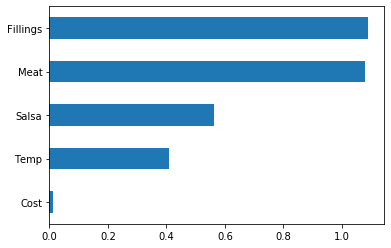

In [110]:
# Plot coefficients
%matplotlib inline
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();